In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import datetime
from datetime import datetime

import sklearn as sk 
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import json

In [2]:
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [3]:
plt.style.use('seaborn-notebook')
plt.rcParams['figure.figsize'] = (18, 9)

font = {'family': 'sans-serif', 
        'style': 'normal', 
        'weight': 'bold', 
        'size': 10}
plt.rc('font', **font)

spot_green = "#1db954"
spot_white = "#ffffff"
spot_black = "#191414"

In [4]:
def get_raw_genres(df, predicted):

    if predicted == -1:
        raw_list = [x for x in df['Genres']]
        print(f"In class {predicted}: {len(df['Genres'])}")
    else:
        raw_list = [x for x in df['Genres'].loc[df['Predictions'] == predicted]]
        print(f"In class {predicted}: {len(df['Genres'].loc[df['Predictions'] == predicted])}")
    
    parsed_list = []

    for entry in raw_list: 
        if entry != "[]":
            stripped = entry[1:-1]
            stripped = stripped.replace("'", '').replace('"', '')
            split = stripped.split(", ")
            parsed_list = parsed_list + split
    
    return parsed_list

In [5]:
def parse_genres(parsed_list, master_list, group_name, total_dict, n=10, k = 3, color = spot_green, relative = True, tens_flag = False):

    if relative: 
        master_list.sort()
        # this finds the proportion of this genre in total
        # and then multiplies it by the count for this group
        # it helps to (slightly) reduce tags that are applied to every song
        count_dict = {key:((parsed_list.count(key) ** 2)/ total_dict[key]) for key in master_list}

    else: 
        master_list.sort()
        count_dict = {key:parsed_list.count(key) for key in master_list}

    count_df = pd.DataFrame.from_dict(count_dict, orient='index')
    count_df = count_df.reset_index(level=0)
    count_df = count_df.rename(columns={0: "Count", "index":"Genre"})

    top_df = count_df.nlargest(n, 'Count')

    fig = plt.figure(1, [20,8])

    ax = fig.add_subplot(111)

    if relative: 
        ax.set_title(f"Group {group_name}\nRelative Frequency")
        ax.set_ylabel(f"Relative Frequency")
    else:
        ax.set_title(f"Group {group_name}\Count")
        ax.set_ylabel(f"Count")

    ax.set_xlabel(f"Genre")
    
    rects = ax.bar(top_df['Genre'], top_df['Count'], color=color)
    plt.setp(ax.get_xticklabels(), rotation=45)

    if tens_flag:
        sub_image = "2010s"
    else:
        sub_image = "full_dataset"

    if relative:
        plt.savefig(f'../data/kmeans/scaled/images/{sub_image}/eps/relative_genres_k{k}_group{group_name}.eps', format = 'eps', transparent = False)
        plt.savefig(f'../data/kmeans/scaled/images/{sub_image}/png/relative_genres_k{k}_group{group_name}.png', format = 'png', transparent = False)
    else: 
        plt.savefig(f'../data/kmeans/scaled/images/{sub_image}/eps/count_genres_k{k}_group{group_name}.eps', format = 'eps', transparent = False)
        plt.savefig(f'../data/kmeans/scaled/images/{sub_image}/png/count_genres_k{k}_group{group_name}.png', format = 'png', transparent = False)

    plt.show()

    return

## Loading

In [6]:
combined_df = pd.read_csv("../data/ingested.csv")

k = 1
tens_flag = True

if tens_flag:
       combined_df['WeekID'] = pd.to_datetime(combined_df['WeekID'], errors='coerce')
       combined_df = combined_df.loc[combined_df['WeekID'] > datetime.strptime("01-01-2010", "%d-%m-%Y")]

# de-duplicate (in case it wasn't before)
de_dup = combined_df.sort_values(by = "WeekID",ascending=True).drop_duplicates(subset = ['SongID'])
de_dup = de_dup.dropna(subset=['Genres'])
names_df = de_dup[["WeekID", "Song", "Performer"]]

features = ['Duration (ms)', 'Explicit',
       'Danceability', 'Energy', 'Key', 'Loudness (db)', 'Mode', 'Speechiness',
       'Acousticness', 'Instrumentalness', 'Liveness', 'Valence', 'Tempo',
       'Time Signature']

X = de_dup[features]

y_name = "pca2"
x_name = "pca1"

scaler = StandardScaler()
scaler.fit(de_dup[features])
X_scaled = scaler.transform(de_dup[features])

my_cmap = mpl.colormaps['tab20']

In [13]:
# fit and train
pca2_raw = PCA(n_components=2)
pca2 = pca2_raw.fit(X_scaled).transform(X_scaled)
pca_2_df = pd.DataFrame(pca2, columns=[x_name, y_name])

# components effect
components_affect_df = pd.DataFrame(pca2_raw.components_ ,columns=X.columns,index = [x_name, y_name])
# explained_variance_df = pd.DataFrame(pca2_raw.explained_variance_ratio_, columns=X.columns,index = [x_name, y_name])
print(components_affect_df)
print(pca2_raw.explained_variance_)

# if tens_flag:
#     components_affect_df.to_csv("../data/kmeans/scaled/2010s_pca_components.csv")
# else:
#     components_affect_df.to_csv("../data/kmeans/scaled/full_dataset_pca_components.csv")

# train model
model = KMeans(k)
model.fit(pca_2_df)
predictions = model.predict(pca_2_df)

# add predictions to df
new_df = de_dup
new_df['Predictions'] = predictions.tolist()
new_df[x_name] = pca_2_df[x_name].values.tolist()
new_df[y_name] = pca_2_df[y_name].values.tolist()

# create cluster list
cluster_list = []
raw_lists = []
master = get_raw_genres(new_df, -1)

# iterate through each genre for raw list
for i in range(0, k):
    raw_list = get_raw_genres(new_df, i)
    cluster_list.append(raw_list)

      Duration (ms)  Explicit  Danceability    Energy       Key  \
pca1       0.067447  0.058857     -0.105475 -0.566955 -0.049570   
pca2      -0.141778  0.579355      0.486997 -0.103005  0.041541   

      Loudness (db)      Mode  Speechiness  Acousticness  Instrumentalness  \
pca1      -0.517792  0.011970     0.013612      0.438851          0.096852   
pca2      -0.127142 -0.227758     0.535763     -0.107359         -0.023147   

      Liveness   Valence     Tempo  Time Signature  
pca1 -0.125039 -0.367425 -0.107508       -0.156095  
pca2  0.061339  0.045480  0.035519        0.143211  
[2.50665147 1.96000164]
In class -1: 4752
In class 0: 4752


In [173]:
# create list of total counts in dataset for each genre
total_dict = {key:0 for key in master}

for index, cluster in enumerate(cluster_list): 
    for genre in cluster: 
        total_dict[genre] += 1

## Cluster Centers

The most average song for full dataset -- Bill Withers: The Love that Made Me Laugh 

The most average song for 2010s -- Ludacris: Sex Room

Total possible genres in this dataset: 1042

In [174]:
from sklearn.metrics import pairwise_distances_argmin_min

closest, _ = pairwise_distances_argmin_min(model.cluster_centers_, pca_2_df)

if tens_flag:
    file_name = f"../data/kmeans/scaled/cluster_centers/2010s/{k}cluster_centers.txt"
else:
    file_name = f"../data/kmeans/scaled/cluster_centers/full_dataset/{k}cluster_centers.txt"

with open(file_name, "w") as f:
    for i in range(k):
        x = model.cluster_centers_[i][0]
        y = model.cluster_centers_[i][1] 
        
        print(f"x-coord: {x}")
        print(f"y-coord: {y}")

        song_id = new_df['SongID'].iloc[closest[i]]
        genre_list = new_df['Genres'].iloc[closest[i]]

        song_name = new_df['Song'].iloc[closest[i]]
        artist_name = new_df['Performer'].iloc[closest[i]]

        f.write("===================\n\n")
        f.write(f"Song center for Group {i}: {song_name}, by {artist_name}\n")
        f.write(f"Genre list for cluster center: {genre_list}\n")
        f.write(f"Coordinates: ({x}, {y})\n")
        f.write("\n")

        print(f"Song center for Group {i}: {song_id}")
        print(f"Genre list: {genre_list}")

x-coord: 1.3055400382166194e-16
y-coord: -1.3971240924365399e-16
Song center for Group 0: Sex RoomLudacris Featuring Trey Songz
Genre list: ['atl hip hop', 'dance pop', 'dirty south rap', 'hip hop', 'pop rap', 'rap', 'southern hip hop', 'trap']


## Plotting

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


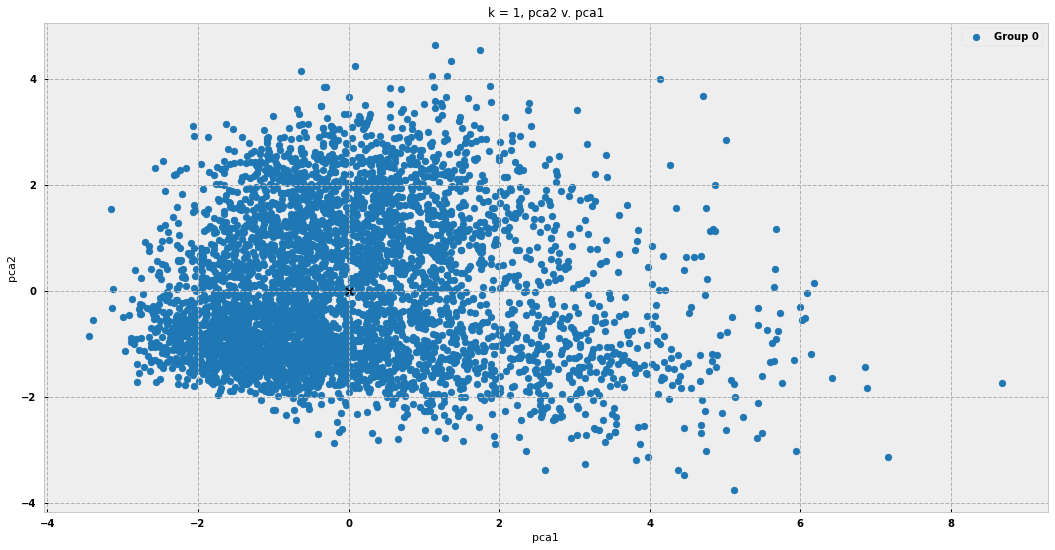

In [175]:
# plot
custom_label_color = [my_cmap.colors[x] for x in predictions]

fig, ax = plt.subplots()

pca_2_df["Group"] = predictions

for i in list(set(predictions)):
    color_index = np.where(predictions == i)[0][0]
    print(custom_label_color[color_index])
    given_df = pca_2_df.loc[pca_2_df['Group'] == i]
    ax.scatter(given_df[x_name], given_df[y_name], color=custom_label_color[color_index], label = f"Group {i}")

plt.scatter(model.cluster_centers_[:,0], model.cluster_centers_[:,1], c="black", marker="x")
plt.xlabel(x_name)
plt.ylabel(y_name)
plt.legend()
plt.title(f"k = {k}, {y_name} v. {x_name}")

if tens_flag:
    plt.savefig(f'../data/kmeans/scaled/images/2010s/eps/clustering_k{k}.eps', format = 'eps', transparent = False)
    plt.savefig(f'../data/kmeans/scaled/images/2010s/png/clustering_k{k}.png', format = 'png', transparent = False)
else: 
    plt.savefig(f'../data/kmeans/scaled/images/full_dataset/eps/clustering_k{k}.eps', format = 'eps', transparent = False)
    plt.savefig(f'../data/kmeans/scaled/images/full_dataset/png/clustering_k{k}.png', format = 'png', transparent = False)

plt.show()

## Graphing

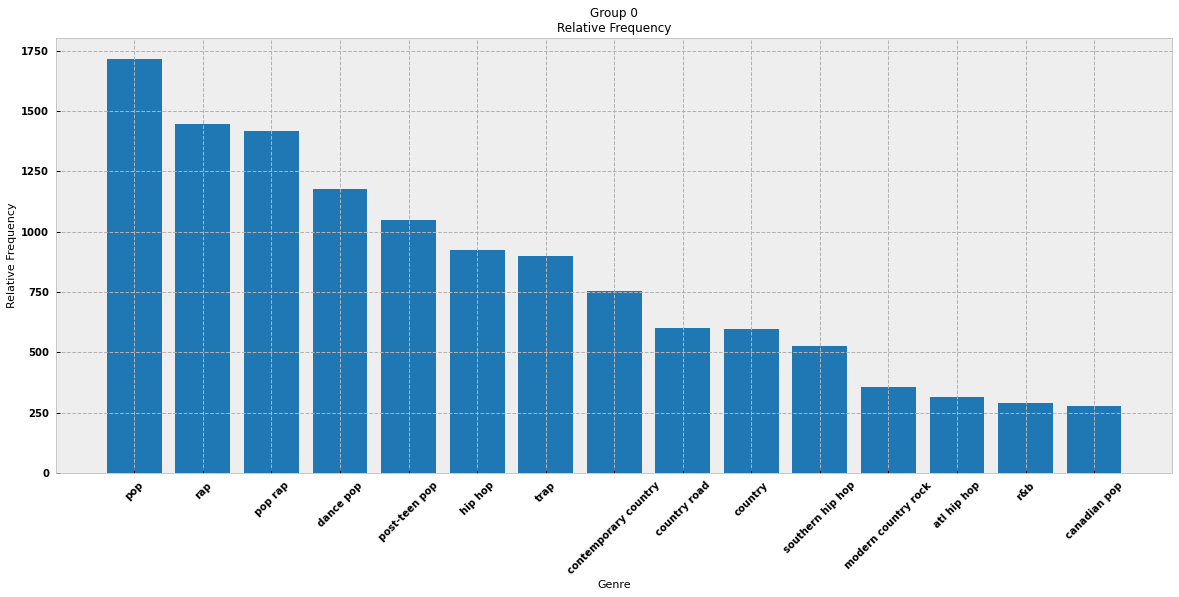

In [176]:
for index, cluster in enumerate(cluster_list):

    color_index = np.where(predictions == index)[0][0]

    parse_genres(cluster, list(set(master)), index, total_dict, n = 15, k = k, tens_flag=tens_flag, relative=True, color = custom_label_color[color_index])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


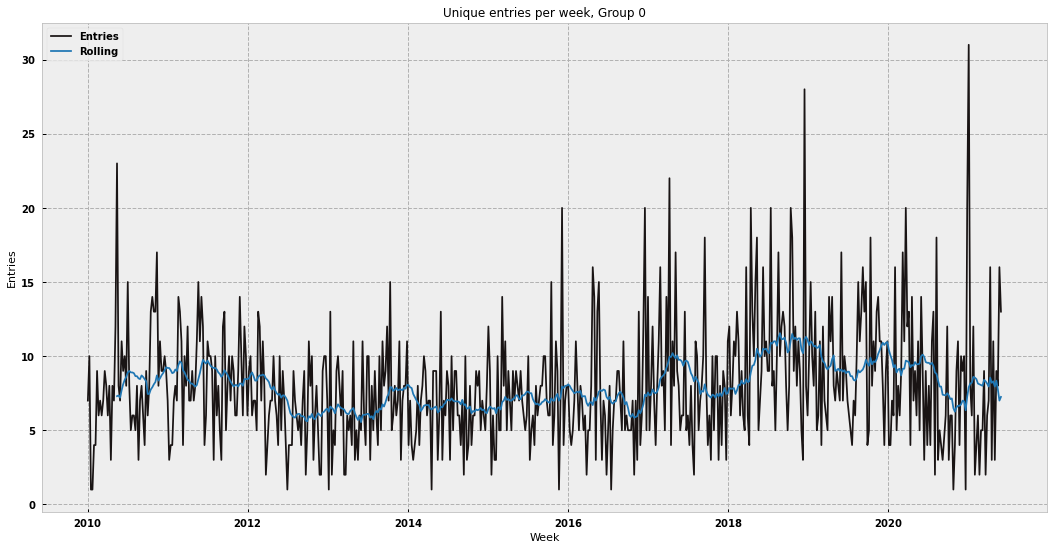

In [177]:
dates_df = new_df
dates_df['WeekID'] = pd.to_datetime(dates_df['WeekID'], errors='coerce')

for i in range(0, len(cluster_list)):

    group_df = dates_df.loc[dates_df['Predictions'] == i].groupby(by='WeekID', as_index=False).count()

    x = np.array(group_df['WeekID'])
    y = np.array(group_df['hot_100_url'])
    rolling = group_df['hot_100_url'].rolling(window=20).mean()

    color_index = np.where(predictions == i)[0][0]

    plt.plot(x,y, label='Entries', color = spot_black)
    plt.plot(x, rolling, label="Rolling", color = custom_label_color[color_index])
    plt.title(f'Unique entries per week, Group {i}')
    plt.xlabel('Week')
    plt.ylabel('Entries')
    plt.legend(loc='upper left')

    if tens_flag:
        plt.savefig(f'../data/kmeans/scaled/images/2010s/eps/prominence_k{k}_group{i}.eps', format = 'eps')
        plt.savefig(f'../data/kmeans/scaled/images/2010s/png/prominence_k{k}_group{i}.png', format = 'png')

    else:
        plt.savefig(f'../data/kmeans/scaled/images/full_dataset/eps/prominence_k{k}_group{i}.eps', format = 'eps')
        plt.savefig(f'../data/kmeans/scaled/images/full_dataset/png/prominence_k{k}_group{i}.png', format = 'png')
        
    plt.show()

In [178]:
if tens_flag:
    sub_folder = "2010s"
else:
    sub_folder = "full_dataset"

new_df.to_csv(f"../data/kmeans/scaled/final_datasets/{sub_folder}/final_k{k}.csv")